### Galaxy-Flux correlation in bins of cz

/tmp/ipykernel_6298/2015554047.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978


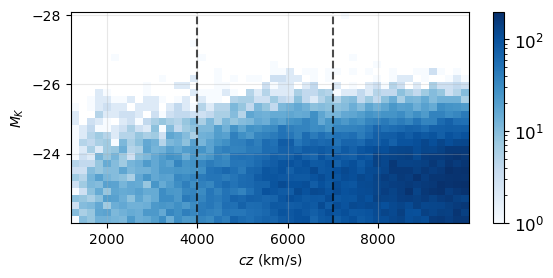

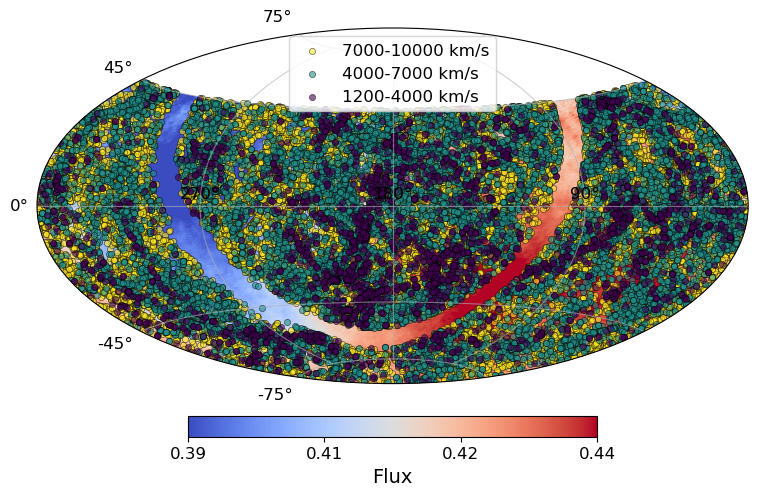

Processing slice: 1200 4000
Number of galaxies in slice 1200-4000: 3240
----- TreeCorr npatch suggestion -----
Survey area            : 35212.0 deg²
Theta max              : 20°
Patch radius           : 11.0°
Patch area             : 380.1 deg²
Ideal npatch (area)    : 93
Max npatch (gal count) : 648
Final suggested npatch : 93
Galaxies per patch     : 34.8
--------------------------------------
Processing slice: 4000 7000
Number of galaxies in slice 4000-7000: 15507
----- TreeCorr npatch suggestion -----
Survey area            : 35212.0 deg²
Theta max              : 20°
Patch radius           : 11.0°
Patch area             : 380.1 deg²
Ideal npatch (area)    : 93
Max npatch (gal count) : 3101
Final suggested npatch : 93
Galaxies per patch     : 166.7
--------------------------------------
Processing slice: 7000 10000
Number of galaxies in slice 7000-10000: 30403
----- TreeCorr npatch suggestion -----
Survey area            : 35212.0 deg²
Theta max              : 20°
Patch radius      

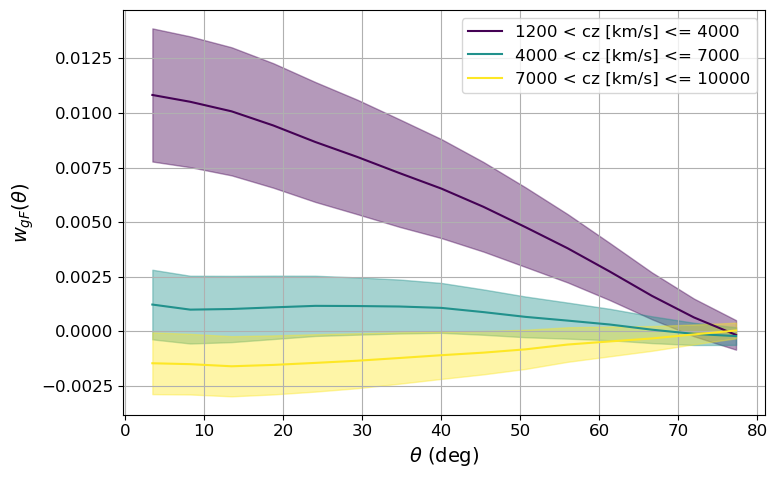

In [2]:
import numpy as np
from astropy.table import Table
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import treecorr
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    from get_masks import get_milkyway_mask

    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458  # km/s
    chunksize = 200_000

    # Read header
    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
        filename,
        delim_whitespace=True,
        names=header,
        usecols=cols_to_use,
        skiprows=1,
        chunksize=chunksize
    ):
        
        # Exclude entries with no redshift
        chunk = chunk[chunk["dist_flag"] != 0]

        # Compute cz
        chunk["cz"] = c * chunk["z_cmb"]

        # Apply the main physical filters
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]

        # Compute absolute K magnitude
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25
        chunk["M_B"] = chunk["B"] - 5 * np.log10(chunk["d_L"]) - 25

        # Apply isfinite mask *inside the loop*
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"])
        chunk = chunk.loc[mask]

        # Append filtered data
        filtered_chunks.append(chunk)

    # Concatenate everything
    df = pd.concat(filtered_chunks, ignore_index=True)
    # Compute absolute K magnitude
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    df = df[df["Dec"] < 45.]

    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]

    print(f"Remaining galaxies after all cuts: {len(df)}")

    return df


def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    from get_masks import get_milkyway_mask

    # Generate random RA and Dec within specified declination limits
    rand_ra = np.random.uniform(0, 360, N_total*3)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total*3
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    # Apply Milky Way mask
    mask = get_milkyway_mask(rand_ra, rand_dec)
    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]
    if len(rand_ra) < N_total:
        raise ValueError(f"Not enough random points generated: {len(rand_ra)} < {N_total}")

    return rand_ra, rand_dec

import numpy as np

def suggest_npatch_from_area(area_deg2,
                              theta_max_deg,
                              N_gal,
                              factor=1.5,
                              min_per_patch=50,
                              verbose=True):
    """
    Suggests a TreeCorr npatch value using:
      - geometric constraint: patch radius > theta_max
      - survey area constraint
      - minimum galaxies per patch

    Parameters
    ----------
    area_deg2 : float
        Survey area in deg^2.
    theta_max_deg : float
        Largest angular scale whose covariance must be trustworthy.
    N_gal : int
        Number of galaxies in the slice.
    factor : float
        Patch radius multiplier: R_patch = factor * theta_max_deg.
    min_per_patch : int
        Minimum acceptable number of galaxies per patch.
    verbose : bool
        Prints diagnostic information.

    Returns
    -------
    npatch : int
        Recommended number of patches.
    """

    # Patch radius and approximate area
    R_patch = factor * (theta_max_deg/2)   # deg
    A_patch = np.pi * R_patch**2       # deg^2

    # Ideal number of patches purely from area
    npatch_ideal = max(1, int(round(area_deg2 / A_patch)))

    # Upper bound from galaxy count constraint
    npatch_max_from_gal = max(1, N_gal // min_per_patch)

    # Combine constraints
    npatch = min(npatch_ideal, npatch_max_from_gal)
    npatch = max(2, npatch)   # At least 2 patches

    if verbose:
        print("----- TreeCorr npatch suggestion -----")
        print(f"Survey area            : {area_deg2:.1f} deg²")
        print(f"Theta max              : {theta_max_deg}°")
        print(f"Patch radius           : {R_patch:.1f}°")
        print(f"Patch area             : {A_patch:.1f} deg²")
        print(f"Ideal npatch (area)    : {npatch_ideal}")
        print(f"Max npatch (gal count) : {npatch_max_from_gal}")
        print(f"Final suggested npatch : {npatch}")
        print(f"Galaxies per patch     : {N_gal/npatch:.1f}")
        print("--------------------------------------")

    return npatch

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'jackknife',
    #"num_bootstrap": 1000,
    "cross_patch_weight": 'match'
}

"""
READ DATA
"""
# === Load galaxy catalogue ===
cols = [
    "GLADE_no", "RA", "Dec", "z_cmb", "K", "B", "d_L", "dist_flag"
]
gxs = read_GLADE(cols)
gxs = gxs[gxs['M_K'] < -22.0]  # Apply absolute magnitude cut

# Validate gxs catalog
# required_columns = ['RA', 'Dec', 'cz']
# for col in required_columns:
#     if col not in gxs.colnames:
#         raise ValueError(f"Missing required column '{col}' in galaxy catalog.")

# === Load flux catalog ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg')#, npatch=10)

"""
VISUALIZE GALAXY DISTRIBUTION BEFORE CORRELATIONS
"""
cz_slices = [(1200, 4000), (4000, 7000), (7000, 10000)]
gxs = gxs[gxs['cz']<=cz_slices[-1][1]]  # limit to max cz for plotting
colors = plt.cm.viridis(np.linspace(0, 1, len(cz_slices)))  # consistent color palette
#colors = ["#2a788e", "#7ad151", "#440154"]

# --- 1. Absolute magnitude vs cz ---
fig, ax = plt.subplots(figsize=(6, 3))
# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 14,     # x/y label
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})

hist2d_cz = ax.hist2d(gxs['cz'], gxs['M_K'], bins=[50, 30], cmap='Blues', norm=plt.matplotlib.colors.LogNorm())
ax.axvline(4000, color='k', linestyle='--', alpha=0.7)
ax.axvline(7000, color='k', linestyle='--', alpha=0.7)

cbar = plt.colorbar(hist2d_cz[3], ax=ax)

ax.set_xlabel(r'$cz$ (km/s)')
ax.set_ylabel(r'$M_K$')
ax.invert_yaxis()  # brighter galaxies at top
#ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../plots/plot2_MK_vs_cz_GLADE.png', dpi=100)
plt.show()

# --- 2. Mollweide skymap ---
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='hammer')

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 14,     # x/y label
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})

# Plot flux
import matplotlib.colors as clrs
norm_flux = clrs.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
mask = np.isfinite(flux_val) # Remove NaNs from flux_val and corresponding positions 
ra_shifted = -np.radians(flux_ra[mask])+np.pi
ra_shifted = ra_shifted[mask]
dec_rad = np.radians(flux_dec[mask])
flux_val = flux_val[mask]
sc = ax.scatter(ra_shifted, dec_rad, c=flux_val, s=15, cmap='coolwarm', norm=norm_flux, edgecolor='none')

# Add horizontal colorbar
cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
cbar_flux.set_label("Flux")
cbar_flux.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# Use only four ticks
cbar_flux.set_ticks(
    np.linspace(norm_flux.vmin, norm_flux.vmax, 4)
)

for i, (cz_min, cz_max) in enumerate(cz_slices[::-1]):
    gxs_slice = gxs[(gxs['cz'] > cz_min) & (gxs['cz'] <= cz_max)]
    ra_rad = np.radians(gxs_slice['RA'])
    dec_rad = np.radians(gxs_slice['Dec'])
    # Convert RA to [-π, π] for proper Mollweide projection
    ra_rad = -ra_rad+np.pi  # flip RA for astronomy convention
    ax.scatter(ra_rad, dec_rad, s=20, alpha=0.6, color=colors[-(i+1)], edgecolor='k', linewidth=.5,\
               label=f'{cz_min}-{cz_max} km/s')

# Set ticks
xticks_deg = [270, 180, 90]
xticks_rad = -np.radians(xticks_deg) + np.pi
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f"{d}°" for d in xticks_deg])

yticks_deg = [-75, -45, 0, 45, 75]
yticks_rad = np.radians(yticks_deg)
ax.set_yticks(yticks_rad)
ax.set_yticklabels([f"{d}°" for d in yticks_deg])
#ax.set_xlabel('Right Ascension')


#ax.set_ylabel('Declination')
ax.legend()#(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(cz_slices))
ax.grid(True, alpha=0.6)
plt.tight_layout()
plt.savefig('../plots/plot2_skymap_galaxies_cz_K.png', dpi=100)
plt.show()


"""
CALCULATE CORRELATIONS FOR CZ SLICES
"""
# cz_slices = [(1200, 4000), (4000, 7000), (7000, 12000)]  # cz slices in km/s
# colors = plt.cm.cividis(np.linspace(0, 1, len(cz_slices)))  # Color gradient

npatch_estimation_params = {'area': 35212, \
                            'theta_max': 20,
                            'factor': 1.1,
                            'min_per_patch': 5}

fig, ax = plt.subplots(figsize=(8, 5))

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 14,     # x/y label
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})

for i, (cz_min, cz_max) in enumerate(cz_slices):

    print('Processing slice:', cz_min, cz_max)

    # Filter galaxies for the current cz slice
    gxs_slice = gxs[(gxs['cz'] > cz_min) & (gxs['cz'] <= cz_max)]
    Ngxs = len(gxs_slice)
    print(f"Number of galaxies in slice {cz_min}-{cz_max}: {Ngxs}")

    # Generate random catalog for the current slice
    rand_ra, rand_dec = generate_RanCat(len(gxs_slice)*100, dec_min=-90, dec_max=45)

    # Create treecorr catalogs for the current slice
    npatch = suggest_npatch_from_area(npatch_estimation_params['area'],
                                      npatch_estimation_params['theta_max'], 
                                      Ngxs, 
                                      factor=npatch_estimation_params['factor'], 
                                      min_per_patch=npatch_estimation_params['min_per_patch'], 
                                      verbose=True)
    
    gcat_slice = treecorr.Catalog(ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
                                  ra_units='deg', dec_units='deg', npatch=npatch)
    rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, 
                                ra_units='deg', dec_units='deg', patch_centers=gcat_slice.patch_centers)
    
    #.........................
    # CHECK PATCH POPULATION
    #.........................
    # Raise Warning for number of scarcely populated patches (<10 galaxies)
    n_patches = len(gcat_slice.patch_centers)
    counts_per_patch = np.bincount(gcat_slice.patch, minlength=n_patches)
    scarcely_populated = np.sum(counts_per_patch < 10)
    if scarcely_populated > 0:
        print(f"Warning: {scarcely_populated} out of {n_patches} patches have less than 10 galaxies.")
        if scarcely_populated > 0.1 * n_patches:
            raise ValueError(f"Error: {scarcely_populated} out of {n_patches} patches have less than 10 galaxies, exceeding the 10% threshold.")
    # Stop if 5% of patches have zero galaxies
    zero_populated = np.sum(counts_per_patch == 0)
    if zero_populated > 0.05 * n_patches:
        raise ValueError(f"Error: {zero_populated} out of {n_patches} patches have zero galaxies, exceeding the 5% threshold.")
    


    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)

    xi, varxi = nk.calculateXi(rk=rk)
    rk_xi = rk.xi.copy()

    xi /= rk_xi  # Normalize by mean flux value
    varxi /= (rk_xi**2)  # Error propagation

    # # Use the raw values and compute correlation manually
    # xi = nk.xi / rk.xi - 1  # This gives (D-R)/R
    # varxi = nk.varxi / (rk.xi**2)  # Error propagation

    plt.fill_between(nk.meanr, xi - varxi**0.5, xi + varxi**0.5, 
                     color=colors[i], alpha=0.4)  # Add error band
    plt.plot(nk.meanr, xi, color=colors[i], label=f'{cz_min} < cz [km/s] <= {cz_max}')

# Add colorbar using a dummy ScalarMappable
# norm = plt.Normalize(vmin=cz_slices[0][0], vmax=cz_slices[-1][1])
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm.set_array([])  # dummy array
# cbar = fig.colorbar(sm, ax=ax)
# cbar.set_label('cz range')

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../plots/plot2_gal_flux_correlation_K.png', dpi=100)  # Save the figure
plt.show()

### Use M_B

/tmp/ipykernel_6298/38252129.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978


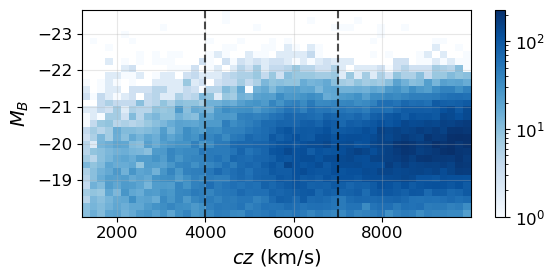

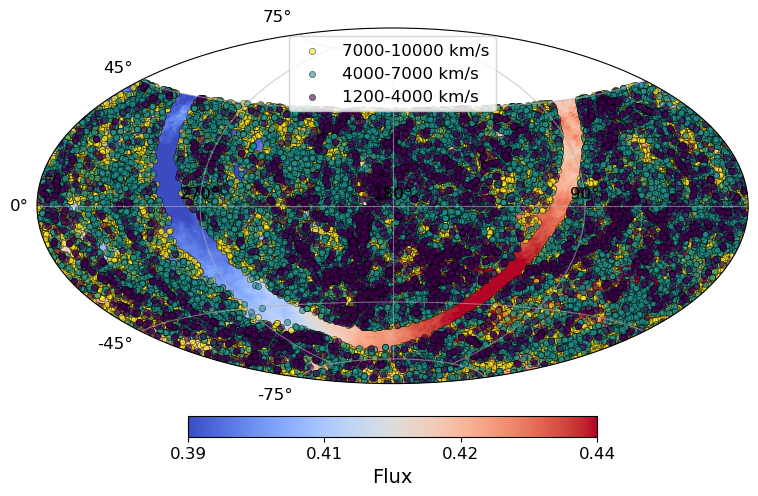

Processing slice: 1200 4000
Number of galaxies in slice 1200-4000: 5090
----- TreeCorr npatch suggestion -----
Survey area            : 35212.0 deg²
Theta max              : 20°
Patch radius           : 11.0°
Patch area             : 380.1 deg²
Ideal npatch (area)    : 93
Max npatch (gal count) : 1018
Final suggested npatch : 93
Galaxies per patch     : 54.7
--------------------------------------
Processing slice: 4000 7000
Number of galaxies in slice 4000-7000: 20585
----- TreeCorr npatch suggestion -----
Survey area            : 35212.0 deg²
Theta max              : 20°
Patch radius           : 11.0°
Patch area             : 380.1 deg²
Ideal npatch (area)    : 93
Max npatch (gal count) : 4117
Final suggested npatch : 93
Galaxies per patch     : 221.3
--------------------------------------
Processing slice: 7000 10000
Number of galaxies in slice 7000-10000: 34629
----- TreeCorr npatch suggestion -----
Survey area            : 35212.0 deg²
Theta max              : 20°
Patch radius     

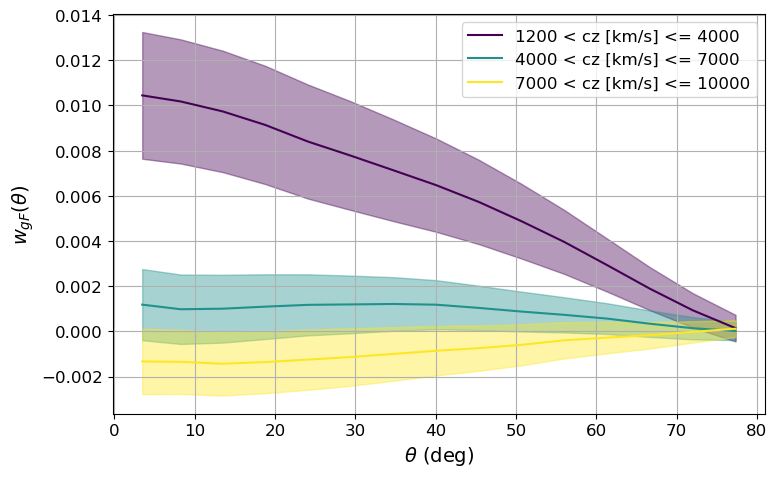

: 

In [ ]:
import numpy as np
from astropy.table import Table
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import treecorr
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    from get_masks import get_milkyway_mask

    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458  # km/s
    chunksize = 200_000

    # Read header
    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
        filename,
        delim_whitespace=True,
        names=header,
        usecols=cols_to_use,
        skiprows=1,
        chunksize=chunksize
    ):
        
        # Exclude entries with no redshift
        chunk = chunk[chunk["dist_flag"] != 0]

        # Compute cz
        chunk["cz"] = c * chunk["z_cmb"]

        # Apply the main physical filters
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]

        # Compute absolute K magnitude
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25
        chunk["M_B"] = chunk["B"] - 5 * np.log10(chunk["d_L"]) - 25

        # Apply isfinite mask *inside the loop*
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"])
        chunk = chunk.loc[mask]

        # Append filtered data
        filtered_chunks.append(chunk)

    # Concatenate everything
    df = pd.concat(filtered_chunks, ignore_index=True)
    # Compute absolute K magnitude
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    df = df[df["Dec"] < 45.]

    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]

    print(f"Remaining galaxies after all cuts: {len(df)}")

    return df


def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    from get_masks import get_milkyway_mask

    # Generate random RA and Dec within specified declination limits
    rand_ra = np.random.uniform(0, 360, N_total*3)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total*3
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    # Apply Milky Way mask
    mask = get_milkyway_mask(rand_ra, rand_dec)
    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]
    if len(rand_ra) < N_total:
        raise ValueError(f"Not enough random points generated: {len(rand_ra)} < {N_total}")

    return rand_ra, rand_dec

import numpy as np

def suggest_npatch_from_area(area_deg2,
                              theta_max_deg,
                              N_gal,
                              factor=1.5,
                              min_per_patch=50,
                              verbose=True):
    """
    Suggests a TreeCorr npatch value using:
      - geometric constraint: patch radius > theta_max
      - survey area constraint
      - minimum galaxies per patch

    Parameters
    ----------
    area_deg2 : float
        Survey area in deg^2.
    theta_max_deg : float
        Largest angular scale whose covariance must be trustworthy.
    N_gal : int
        Number of galaxies in the slice.
    factor : float
        Patch radius multiplier: R_patch = factor * theta_max_deg.
    min_per_patch : int
        Minimum acceptable number of galaxies per patch.
    verbose : bool
        Prints diagnostic information.

    Returns
    -------
    npatch : int
        Recommended number of patches.
    """

    # Patch radius and approximate area
    R_patch = factor * (theta_max_deg/2)   # deg
    A_patch = np.pi * R_patch**2       # deg^2

    # Ideal number of patches purely from area
    npatch_ideal = max(1, int(round(area_deg2 / A_patch)))

    # Upper bound from galaxy count constraint
    npatch_max_from_gal = max(1, N_gal // min_per_patch)

    # Combine constraints
    npatch = min(npatch_ideal, npatch_max_from_gal)
    npatch = max(2, npatch)   # At least 2 patches

    if verbose:
        print("----- TreeCorr npatch suggestion -----")
        print(f"Survey area            : {area_deg2:.1f} deg²")
        print(f"Theta max              : {theta_max_deg}°")
        print(f"Patch radius           : {R_patch:.1f}°")
        print(f"Patch area             : {A_patch:.1f} deg²")
        print(f"Ideal npatch (area)    : {npatch_ideal}")
        print(f"Max npatch (gal count) : {npatch_max_from_gal}")
        print(f"Final suggested npatch : {npatch}")
        print(f"Galaxies per patch     : {N_gal/npatch:.1f}")
        print("--------------------------------------")

    return npatch

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'jackknife',
    #"num_bootstrap": 1000,
    "cross_patch_weight": 'match'
}

"""
READ DATA
"""
# === Load galaxy catalogue ===
cols = [
    "GLADE_no", "RA", "Dec", "z_cmb", "K", "B", "d_L", "dist_flag"
]
gxs = read_GLADE(cols)
#gxs = gxs[gxs['M_K'] < -22.0]  # Apply absolute magnitude cut
gxs = gxs[gxs['M_B'] < -18.0]  # Apply absolute magnitude cut

# Validate gxs catalog
# required_columns = ['RA', 'Dec', 'cz']
# for col in required_columns:
#     if col not in gxs.colnames:
#         raise ValueError(f"Missing required column '{col}' in galaxy catalog.")

# === Load flux catalog ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg')#, npatch=10)

"""
VISUALIZE GALAXY DISTRIBUTION BEFORE CORRELATIONS
"""
cz_slices = [(1200, 4000), (4000, 7000), (7000, 10000)]
gxs = gxs[gxs['cz']<=cz_slices[-1][1]]  # limit to max cz for plotting
colors = plt.cm.viridis(np.linspace(0, 1, len(cz_slices)))  # consistent color palette
#colors = ["#2a788e", "#7ad151", "#440154"]

# --- 1. Absolute magnitude vs cz ---
fig, ax = plt.subplots(figsize=(6, 3))
# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 14,     # x/y label
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})

hist2d_cz = ax.hist2d(gxs['cz'], gxs['M_B'], bins=[50, 30], cmap='Blues', norm=plt.matplotlib.colors.LogNorm())
ax.axvline(4000, color='k', linestyle='--', alpha=0.7)
ax.axvline(7000, color='k', linestyle='--', alpha=0.7)

cbar = plt.colorbar(hist2d_cz[3], ax=ax)

ax.set_xlabel(r'$cz$ (km/s)')
ax.set_ylabel(r'$M_B$')
ax.invert_yaxis()  # brighter galaxies at top
#ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../plots/plot2_MB_vs_cz_GLADE.png', dpi=100)
plt.show()

# --- 2. Mollweide skymap ---
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='hammer')

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 14,     # x/y label
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})

# Plot flux
import matplotlib.colors as clrs
norm_flux = clrs.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
mask = np.isfinite(flux_val) # Remove NaNs from flux_val and corresponding positions 
ra_shifted = -np.radians(flux_ra[mask])+np.pi
ra_shifted = ra_shifted[mask]
dec_rad = np.radians(flux_dec[mask])
flux_val = flux_val[mask]
sc = ax.scatter(ra_shifted, dec_rad, c=flux_val, s=15, cmap='coolwarm', norm=norm_flux, edgecolor='none')

# Add horizontal colorbar
cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
cbar_flux.set_label("Flux")
cbar_flux.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# Use only four ticks
cbar_flux.set_ticks(
    np.linspace(norm_flux.vmin, norm_flux.vmax, 4)
)

for i, (cz_min, cz_max) in enumerate(cz_slices[::-1]):
    gxs_slice = gxs[(gxs['cz'] > cz_min) & (gxs['cz'] <= cz_max)]
    ra_rad = np.radians(gxs_slice['RA'])
    dec_rad = np.radians(gxs_slice['Dec'])
    # Convert RA to [-π, π] for proper Mollweide projection
    ra_rad = -ra_rad+np.pi  # flip RA for astronomy convention
    ax.scatter(ra_rad, dec_rad, s=20, alpha=0.6, color=colors[-(i+1)], edgecolor='k', linewidth=.5,\
               label=f'{cz_min}-{cz_max} km/s')

# Set ticks
xticks_deg = [270, 180, 90]
xticks_rad = -np.radians(xticks_deg) + np.pi
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f"{d}°" for d in xticks_deg])

yticks_deg = [-75, -45, 0, 45, 75]
yticks_rad = np.radians(yticks_deg)
ax.set_yticks(yticks_rad)
ax.set_yticklabels([f"{d}°" for d in yticks_deg])
#ax.set_xlabel('Right Ascension')


#ax.set_ylabel('Declination')
ax.legend()#(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(cz_slices))
ax.grid(True, alpha=0.6)
plt.tight_layout()
plt.savefig('../plots/plot2_skymap_galaxies_cz_B.png', dpi=100)
plt.show()


"""
CALCULATE CORRELATIONS FOR CZ SLICES
"""
# cz_slices = [(1200, 4000), (4000, 7000), (7000, 12000)]  # cz slices in km/s
# colors = plt.cm.cividis(np.linspace(0, 1, len(cz_slices)))  # Color gradient

npatch_estimation_params = {'area': 35212, \
                            'theta_max': 20,
                            'factor': 1.1,
                            'min_per_patch': 5}

fig, ax = plt.subplots(figsize=(8, 5))

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 14,     # x/y label
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})

for i, (cz_min, cz_max) in enumerate(cz_slices):

    print('Processing slice:', cz_min, cz_max)

    # Filter galaxies for the current cz slice
    gxs_slice = gxs[(gxs['cz'] > cz_min) & (gxs['cz'] <= cz_max)]
    Ngxs = len(gxs_slice)
    print(f"Number of galaxies in slice {cz_min}-{cz_max}: {Ngxs}")

    # Generate random catalog for the current slice
    rand_ra, rand_dec = generate_RanCat(len(gxs_slice)*100, dec_min=-90, dec_max=45)

    # Create treecorr catalogs for the current slice
    npatch = suggest_npatch_from_area(npatch_estimation_params['area'],
                                      npatch_estimation_params['theta_max'], 
                                      Ngxs, 
                                      factor=npatch_estimation_params['factor'], 
                                      min_per_patch=npatch_estimation_params['min_per_patch'], 
                                      verbose=True)
    
    gcat_slice = treecorr.Catalog(ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
                                  ra_units='deg', dec_units='deg', npatch=npatch)
    rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, 
                                ra_units='deg', dec_units='deg', patch_centers=gcat_slice.patch_centers)
    
    #.........................
    # CHECK PATCH POPULATION
    #.........................
    # Raise Warning for number of scarcely populated patches (<10 galaxies)
    n_patches = len(gcat_slice.patch_centers)
    counts_per_patch = np.bincount(gcat_slice.patch, minlength=n_patches)
    scarcely_populated = np.sum(counts_per_patch < 10)
    if scarcely_populated > 0:
        print(f"Warning: {scarcely_populated} out of {n_patches} patches have less than 10 galaxies.")
        if scarcely_populated > 0.1 * n_patches:
            raise ValueError(f"Error: {scarcely_populated} out of {n_patches} patches have less than 10 galaxies, exceeding the 10% threshold.")
    # Stop if 5% of patches have zero galaxies
    zero_populated = np.sum(counts_per_patch == 0)
    if zero_populated > 0.05 * n_patches:
        raise ValueError(f"Error: {zero_populated} out of {n_patches} patches have zero galaxies, exceeding the 5% threshold.")
    


    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)

    xi, varxi = nk.calculateXi(rk=rk)
    rk_xi = rk.xi.copy()

    xi /= rk_xi  # Normalize by mean flux value
    varxi /= (rk_xi**2)  # Error propagation

    # # Use the raw values and compute correlation manually
    # xi = nk.xi / rk.xi - 1  # This gives (D-R)/R
    # varxi = nk.varxi / (rk.xi**2)  # Error propagation

    plt.fill_between(nk.meanr, xi - varxi**0.5, xi + varxi**0.5, 
                     color=colors[i], alpha=0.4)  # Add error band
    plt.plot(nk.meanr, xi, color=colors[i], label=f'{cz_min} < cz [km/s] <= {cz_max}')

# Add colorbar using a dummy ScalarMappable
# norm = plt.Normalize(vmin=cz_slices[0][0], vmax=cz_slices[-1][1])
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm.set_array([])  # dummy array
# cbar = fig.colorbar(sm, ax=ax)
# cbar.set_label('cz range')

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../plots/plot2_gal_flux_correlation_B.png', dpi=100)  # Save the figure
plt.show()